### Préambule : création d'un transformeur

In [76]:
import numpy as np
from numpy.random import rand
from sklearn.base import TransformerMixin

class Inverseur2x2(TransformerMixin):
    def __init__(self):         
        self.det = 0                    # L'attribut det est initialisé à 0 lors de l'instanciation
    
    def fit(self, X):
        if X.shape != (2, 2):           # L'attribut shape d'un array donne les dimensions de la matrice
            print("La matrice n'est pas de dimension 2x2")
            return
        self.det = X[0,0] * X[1,1] - X[0,1] * X[1,0]    # det = ad -bc
        
        return self
        
    
    def transform(self,X):
        if self.det == 0:               # Il faut que le déterminant soit non-nul pour que la matrice soit inversible.
            print("La matrice n'est pas inversible")
            return
        Y = np.zeros([2, 2])   # Création d'une nouvelle matrice 2x2
        Y[0, 0] = X[1, 1]                              
        Y[1, 1] = X[0, 0]
        Y[0, 1] = - X[0, 1]
        Y[1, 0] = - X[1, 0]
        return (1/self.det) * Y
        
inverseur = Inverseur2x2()

X = rand(2,2)
Y = inverseur.fit_transform(X)

print (X)
print (Y)

[[0.39787802 0.11247211]
 [0.12327508 0.1210116 ]]
[[ 3.52979998 -3.28071058]
 [-3.59582349 11.60574545]]


### Récupération du dataset

In [77]:
import kagglehub as kh
import pandas as pd

# Télécharger le dataset dans un dossier local
dataset_ref = "dileep070/heart-disease-prediction-using-logistic-regression"
path = kh.dataset_download(dataset_ref)

# Localiser le fichier CSV dans le dossier téléchargé
csv_file = f"{path}/framingham.csv"

# Charger le fichier CSV dans un DataFrame
df = pd.read_csv(csv_file)

# Afficher les premières lignes
display(df.head())


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


### Gestion des doublons et valeurs manquantes

In [79]:
# Vérifier l'absence de doublons
print(df.duplicated().sum())

# Vérifier l'absence de valeurs nulles
print(df.isna().sum())

# On les traitera dans la pipeline de preprocessing

0
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


### Vérification de la validité des données

In [80]:
# Vérifier l'ensemble des valeurs distinctes pour les données catégorielles
print(df['male'].unique())
print(df['education'].unique())
print(df['currentSmoker'].unique())
print(df['BPMeds'].unique())
print(df['prevalentStroke'].unique())
print(df['prevalentHyp'].unique())
print(df['diabetes'].unique())
print(df['TenYearCHD'].unique())

[1 0]
[ 4.  2.  1.  3. nan]
[0 1]
[ 0.  1. nan]
[0 1]
[0 1]
[0 1]
[0 1]


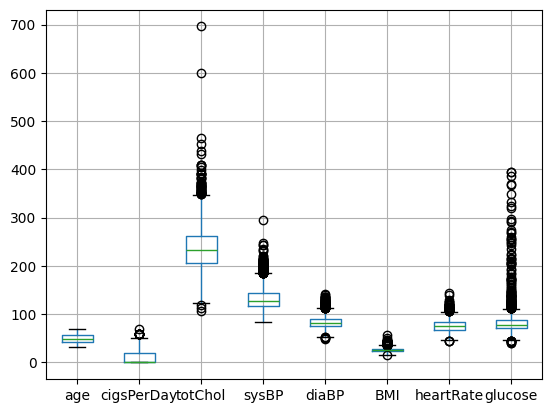

In [81]:
# Vérifier la distribution des données quantitatives avec des boxplots
import matplotlib.pyplot as plt
df.boxplot(column=['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'])
plt.show()
# Les données semblent cohérentes

### Pipeline avec Transformeur spécialisé

#### Transformation cigarettes par jour en paquets par jour

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin

# Classe ColumnBucketer : Création d'une nouvelle colonne qui correspond à la segmentation d'une autre
class ColumnBucketer(BaseEstimator,TransformerMixin):
    def __init__(self,column_name,bucket_size,new_name):
        self.column_name = column_name
        self.bucket_size = bucket_size
        self.new_name = new_name
        
    def fit(self,X,y=None):
        return (self)
    
    def transform(self,X):
        X = X.copy()
        X[self.new_name]=X[self.column_name] // self.bucket_size
        return (X[[self.new_name]])
    
    def get_feature_names_out(self, input_features=None):
        return np.array([self.new_name])

# Transformeur qui crée une nouvelle colonne PaquetsParJour
seg_cigs = ColumnBucketer("cigsPerDay",20,"PaquetsParJour")

In [83]:
XforTrans = df.drop(['TenYearCHD'],axis=1).copy()
display(seg_cigs.fit_transform(XforTrans))


,PaquetsParJour
0,0.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
4233,0.0
4234,2.0
4235,1.0
4236,0.0


#### Pipeline : tranformation en paquets + gestion NAN + standardisation

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

cigs_si = SimpleImputer(strategy="mean")
cigs_st = StandardScaler()

CigsPipeline = Pipeline(steps=[
    ("CigsToPaquets",seg_cigs),
    ("GestionNAN",cigs_si),
    ("Standardisation",cigs_st)
]) 

In [85]:
XforTrans = df.drop(['TenYearCHD'],axis=1).copy()
Xtransformed = CigsPipeline.fit_transform(XforTrans)
display(Xtransformed)
display((Xtransformed==np.nan).sum())


array([[-0.58805791],
       [-0.58805791],
       [ 1.22922237],
       ...,
       [ 1.22922237],
       [-0.58805791],
       [-0.58805791]], shape=(4238, 1))

np.int64(0)

### Pipeline pour variables numériques : gestion NAN + standardisation

In [86]:
num_si = SimpleImputer(strategy="mean")
num_st = StandardScaler()

NumericalPipeline = Pipeline(steps=[
    ('GestionNAN',num_si),
    ('Standardisation',num_st)
])

In [87]:
num = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
XforTrans = df[num].copy()
Xtransformed = NumericalPipeline.fit_transform(XforTrans)
display(Xtransformed)
display((Xtransformed==np.nan).sum())

array([[-1.23495068, -0.94134554, -1.19590711, ...,  0.28694273,
         0.34274444, -0.21751656],
       [-0.41825733,  0.29959495, -0.51518725, ...,  0.71932499,
         1.59027451, -0.26131108],
       [-0.18491638,  0.18678218, -0.22020864, ..., -0.11350221,
        -0.07309892, -0.52407818],
       ...,
       [-0.18491638,  0.25446984, -0.06137401, ..., -0.93404582,
         0.67541912,  0.17663409],
       [-0.65159829, -0.60290723, -0.26558997, ..., -1.63175357,
         0.84175647,  0.        ],
       [ 0.28176554,  0.72828348,  0.0520793 , ..., -1.06425185,
         0.34274444,  1.09631895]], shape=(4238, 7))

np.int64(0)

### Pipeline pour variables catégorielles : gestion NAN + encodage

In [88]:
from sklearn.preprocessing import OneHotEncoder

cat_si = SimpleImputer(strategy="most_frequent")
cat_st = OneHotEncoder()

CategorialPipeline = Pipeline(steps=[
    ('GestionNAN',cat_si),
    ('Encodage',cat_st)
])

In [89]:
cat = ['male','education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']
XforTrans = df[cat].copy()
Xtransformed = CategorialPipeline.fit_transform(XforTrans)
display(Xtransformed)
display((Xtransformed==np.nan).sum())

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 29666 stored elements and shape (4238, 16)>

np.int64(0)

### Pipeline pour preprocessing : utilisation de ColumnTransformer

In [90]:
from sklearn.compose import ColumnTransformer

# On va appliquer les 3 pipelines ci-dessus en parallèle
# Chaque pipeline transforme sa ou ses colonnes
preprocessor = ColumnTransformer([
    ('PipelineCigarettes', CigsPipeline, ['cigsPerDay']),
    ('PipelineNumeriques', NumericalPipeline, num),
    ('PipelineCategorie', CategorialPipeline, cat)
])
#,remainder='passthrough'

In [91]:
XforTrans = df.drop(columns='TenYearCHD').copy()
Xtransformed = preprocessor.fit_transform(XforTrans)
display(pd.DataFrame(Xtransformed,columns=preprocessor.get_feature_names_out()))
display((Xtransformed==np.nan).sum())
display(XforTrans) # Le ColumnTransfomer travaille toujours sur des colonnes COPIEES => Le dataset d'origine est inchangé

,PipelineCigarettes__PaquetsParJour,PipelineNumeriques__age,PipelineNumeriques__totChol,PipelineNumeriques__sysBP,PipelineNumeriques__diaBP,PipelineNumeriques__BMI,PipelineNumeriques__heartRate,PipelineNumeriques__glucose,PipelineCategorie__male_0.0,PipelineCategorie__male_1.0,...,PipelineCategorie__currentSmoker_0.0,PipelineCategorie__currentSmoker_1.0,PipelineCategorie__BPMeds_0.0,PipelineCategorie__BPMeds_1.0,PipelineCategorie__prevalentStroke_0.0,PipelineCategorie__prevalentStroke_1.0,PipelineCategorie__prevalentHyp_0.0,PipelineCategorie__prevalentHyp_1.0,PipelineCategorie__diabetes_0.0,PipelineCategorie__diabetes_1.0
0,-0.588058,-1.234951,-0.941346,-1.195907,-1.082625,0.286943,0.342744,-0.217517,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.588058,-0.418257,0.299595,-0.515187,-0.158988,0.719325,1.590275,-0.261311,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.229222,-0.184916,0.186782,-0.220209,-0.242955,-0.113502,-0.073099,-0.524078,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.229222,1.331800,-0.264469,0.800871,1.016549,0.682474,-0.904786,0.921141,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,1.229222,-0.418257,1.089284,-0.106755,0.092912,-0.663807,0.758588,0.132840,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,-0.588058,0.048425,1.721036,2.116930,0.764648,0.041271,-0.821617,0.176634,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4234,3.046503,0.165095,-0.670595,-0.265590,-0.242955,-1.496634,-0.904786,-0.611667,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4235,1.229222,-0.184916,0.254470,-0.061374,-0.914691,-0.934046,0.675419,0.176634,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4236,-0.588058,-0.651598,-0.602907,-0.265590,0.344813,-1.631754,0.841756,0.000000,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


np.int64(0)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN


### Pipeline finale : preprocessing + modèle

In [92]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

FinalPipeline = Pipeline(steps=[
    ('Preprocessing',preprocessor),
    ('Modeling',logreg)
])

### Séparation entraînement et test

In [93]:
# Séparation features / target
X = df.drop(columns='TenYearCHD')
y = df['TenYearCHD']

# Séparation training / testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Entraînement et test sur la pipeline

In [94]:
# Entraînement
FinalPipeline.fit(X_train,y_train)

# Score et prédiction
print(FinalPipeline.score(X_test,y_test))
y_pred = FinalPipeline.predict(X_test)

# Afficher la matrice de confusion
display(pd.crosstab(y_test,y_pred,rownames=["Réel"],colnames=["Prédit"]))

# Afficher le rapport de classification
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred)
print(class_report)

0.8596698113207547


Prédit,0,1
Réel,,
0,719,5
1,114,10


              precision    recall  f1-score   support

           0       0.86      0.99      0.92       724
           1       0.67      0.08      0.14       124

    accuracy                           0.86       848
   macro avg       0.76      0.54      0.53       848
weighted avg       0.83      0.86      0.81       848



#### Sous-pipeline

In [95]:
# Pipeline jusqu'à l'étape de preprocessing
sub_pipe = FinalPipeline[:1]
X_train_transformed = sub_pipe.fit_transform(X_train,y_train)
display (X_train)
display (pd.DataFrame(X_train_transformed,columns=sub_pipe.get_feature_names_out()))

X_test_transformed = sub_pipe.transform(X_test)
display (X_test)
display (pd.DataFrame(X_test_transformed,columns=sub_pipe.get_feature_names_out()))


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3252,1,40,4.0,1,30.0,0.0,0,0,0,205.0,131.0,81.0,23.74,66.0,87.0
3946,0,57,2.0,0,0.0,0.0,0,1,0,250.0,152.5,92.5,32.31,75.0,94.0
1261,0,47,1.0,0,0.0,0.0,0,0,0,230.0,123.0,71.0,26.98,83.0,73.0
2536,1,41,2.0,1,30.0,0.0,0,0,0,228.0,113.0,82.5,25.67,67.0,70.0
4089,0,64,1.0,0,0.0,0.0,0,1,0,232.0,149.5,84.0,20.49,68.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0,36,1.0,1,5.0,0.0,0,1,0,222.0,147.0,94.0,26.79,76.0,71.0
466,0,57,3.0,1,15.0,0.0,0,0,0,250.0,125.0,74.0,21.08,80.0,72.0
3092,0,60,2.0,0,0.0,0.0,0,1,0,298.0,133.0,89.0,25.09,83.0,81.0
3772,1,39,2.0,1,10.0,0.0,0,0,0,215.0,102.0,64.5,24.50,68.0,62.0


,PipelineCigarettes__PaquetsParJour,PipelineNumeriques__age,PipelineNumeriques__totChol,PipelineNumeriques__sysBP,PipelineNumeriques__diaBP,PipelineNumeriques__BMI,PipelineNumeriques__heartRate,PipelineNumeriques__glucose,PipelineCategorie__male_0.0,PipelineCategorie__male_1.0,...,PipelineCategorie__currentSmoker_0.0,PipelineCategorie__currentSmoker_1.0,PipelineCategorie__BPMeds_0.0,PipelineCategorie__BPMeds_1.0,PipelineCategorie__prevalentStroke_0.0,PipelineCategorie__prevalentStroke_1.0,PipelineCategorie__prevalentHyp_0.0,PipelineCategorie__prevalentHyp_1.0,PipelineCategorie__diabetes_0.0,PipelineCategorie__diabetes_1.0
0,1.216418,-1.110334,-0.716699,-0.062841,-0.165921,-0.511018,-0.837799,0.221112,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.592889,0.871963,0.295059,0.909287,0.795214,1.575841,-0.083446,0.530608,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.592889,-0.294094,-0.154611,-0.424563,-1.001691,0.277946,0.587090,-0.397881,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.216418,-0.993728,-0.199578,-0.876716,-0.040556,-0.041049,-0.753982,-0.530522,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.592889,1.688203,-0.109644,0.773641,0.084810,-1.302417,-0.670165,0.619036,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,-0.592889,-1.576756,-0.334479,0.660603,0.920580,0.231680,0.000371,-0.486308,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3386,-0.592889,0.871963,0.295059,-0.334133,-0.750960,-1.158748,0.335639,-0.442094,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3387,-0.592889,1.221780,1.374267,0.027589,0.502695,-0.182283,0.587090,-0.044171,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3388,-0.592889,-1.226939,-0.491864,-1.374084,-1.544942,-0.325952,-0.670165,-0.884232,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3188,1,63,1.0,0,0.0,0.0,0,1,0,190.0,148.0,90.0,27.13,72.0,86.0
764,1,45,3.0,0,0.0,0.0,0,0,0,162.0,125.0,89.0,27.98,85.0,83.0
3264,0,51,1.0,1,2.0,0.0,0,0,0,261.0,127.0,81.0,20.24,75.0,96.0
1967,1,45,3.0,1,30.0,0.0,0,0,0,250.0,126.0,89.5,28.68,75.0,92.0
2185,0,45,2.0,1,3.0,0.0,0,0,0,250.0,130.0,80.0,20.24,90.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3303,1,47,1.0,0,0.0,0.0,0,0,0,259.0,139.0,79.0,29.34,70.0,71.0
4056,1,44,2.0,0,0.0,0.0,0,0,0,254.0,130.0,80.0,28.15,80.0,74.0
4210,1,50,1.0,0,0.0,0.0,0,0,0,282.0,126.5,88.0,27.30,85.0,87.0
3971,1,64,3.0,0,0.0,0.0,0,1,1,195.0,176.0,78.0,24.90,95.0,370.0


,PipelineCigarettes__PaquetsParJour,PipelineNumeriques__age,PipelineNumeriques__totChol,PipelineNumeriques__sysBP,PipelineNumeriques__diaBP,PipelineNumeriques__BMI,PipelineNumeriques__heartRate,PipelineNumeriques__glucose,PipelineCategorie__male_0.0,PipelineCategorie__male_1.0,...,PipelineCategorie__currentSmoker_0.0,PipelineCategorie__currentSmoker_1.0,PipelineCategorie__BPMeds_0.0,PipelineCategorie__BPMeds_1.0,PipelineCategorie__prevalentStroke_0.0,PipelineCategorie__prevalentStroke_1.0,PipelineCategorie__prevalentHyp_0.0,PipelineCategorie__prevalentHyp_1.0,PipelineCategorie__diabetes_0.0,PipelineCategorie__diabetes_1.0
0,-0.592889,1.571597,-1.053951,0.705818,0.586272,0.314472,-0.334897,0.176898,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,-0.592889,-0.527305,-1.683490,-0.334133,0.502695,0.521454,0.754724,0.044257,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.592889,0.172329,0.542378,-0.243702,-0.165921,-1.363294,-0.083446,0.619036,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.216418,-0.527305,0.295059,-0.288918,0.544483,0.691909,-0.083446,0.442181,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.592889,-0.527305,0.295059,-0.108057,-0.249498,-1.363294,1.173808,0.176898,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,-0.592889,-0.294094,0.497411,0.298881,-0.333075,0.852624,-0.502531,-0.486308,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
844,-0.592889,-0.643911,0.384993,-0.108057,-0.249498,0.562850,0.335639,-0.353667,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
845,-0.592889,0.055723,1.014531,-0.266310,0.419118,0.355869,0.754724,0.221112,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
846,-0.592889,1.688203,-0.941534,1.971846,-0.416652,-0.228549,1.592893,12.733604,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


### GridSearch avec Pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

#params = {  'standardiation_encodate__standardisation':[MinMaxScaler(),StandardScaler()], # Standardisation : min-max ou ou standard
#            'standardiation_encodate__encodage__drop': [None,'first'], # Encodage : avec ou sans suppression de la première ligne
#            'model__C': [0.01, 0.1, 1, 10], # Hyperparamètre C de LogRegression
#            'model__solver': ['liblinear', 'lbfgs'], # Hyperparamètre solver de LogRegression
#            'model__class_weight':[None,'balanced'] # Hyperparamètre class_weight de LogRegression
#          }

params = {
    #'Preprocessing':[preprocessor,SimpleImputer(),"passthrough"], # si on veut tester avec ou sans preprocessing
    'Preprocessing__PipelineNumeriques__Standardisation':[MinMaxScaler(),StandardScaler()], # Standardisation ou normalisation des colonnes numériques
    'Preprocessing__PipelineCigarettes__Standardisation':[MinMaxScaler(),StandardScaler()], # Standardisation ou normalisation de la colonne cigarettes
    #'Preprocessing__PipelineCigarettes__CigsToPaquets':[seg_cigs,"passthrough"], # si on veut tester avec ou sans segmentation des cigarettes en paquets
    'Preprocessing__PipelineCigarettes__CigsToPaquets__bucket_size':[5,10,15,20], # Taille du paquet pour la segmentation de la colonne cigarettes
    'Modeling__C': [0.01, 0.1, 1, 10], # Hyperparamètre C de LogRegression
    'Modeling__solver': ['liblinear', 'lbfgs'], # Hyperparamètre solver de LogRegression
    'Modeling__class_weight':[None,'balanced'] # Hyperparamètre class_weight de LogRegression
          }

grid = GridSearchCV(FinalPipeline,params,cv=5,scoring='f1')
grid.fit(X_train,y_train)

print ("Best params : ",grid.best_params_)
print ("Best score : ",grid.best_score_)


Best params :  {'Modeling__C': 10, 'Modeling__class_weight': 'balanced', 'Modeling__solver': 'lbfgs', 'Preprocessing__PipelineCigarettes__CigsToPaquets__bucket_size': 20, 'Preprocessing__PipelineCigarettes__Standardisation': StandardScaler(), 'Preprocessing__PipelineNumeriques__Standardisation': MinMaxScaler()}
Best score :  0.3934667424272882


In [101]:
# Score et prédiction
print(grid.score(X_test,y_test))
y_pred = grid.predict(X_test)

# Afficher la matrice de confusion
display(pd.crosstab(y_test,y_pred,rownames=["Réel"],colnames=["Prédit"]))

# Afficher le rapport de classification
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred)
print(class_report)

0.35555555555555557


Prédit,0,1
Réel,,
0,478,246
1,44,80


              precision    recall  f1-score   support

           0       0.92      0.66      0.77       724
           1       0.25      0.65      0.36       124

    accuracy                           0.66       848
   macro avg       0.58      0.65      0.56       848
weighted avg       0.82      0.66      0.71       848

